In [7]:
!git clone https://github.com/ChenghaoLyu/CV-Project.git

Cloning into 'CV-Project'...
remote: Enumerating objects: 8057, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 8057 (delta 11), reused 34 (delta 7), pack-reused 8018
Receiving objects: 100% (8057/8057), 134.81 MiB | 34.53 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (8053/8053), done.


In [167]:
!nvidia-smi

Tue Oct 17 14:48:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |  14571MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [241]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


target_shape = (200, 245)

In [242]:

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [243]:
root = "CV-Project/"
anchor_images_path = "CV-Project/train/left"
positive_images_path = "CV-Project/train/right"

In [244]:

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [245]:
df=pd.read_csv(root + "train.csv")

In [246]:
import os
train_left = []
train_right = []
val_left = []
val_right = []
for i in range(1900):
    train_left.append(root + "train/left/" + df.left[i] + '.jpg')
    train_right.append(root + "train/right/" + df.right[i] +'.jpg')
for i in range(1900,2000):
    val_left.append(root + "train/left/" + df.left[i] + '.jpg')
    val_right.append(root + "train/right/" + df.right[i] +'.jpg')

directory_path = root + "train/right/"
all_items = os.listdir(directory_path)

# 过滤出只是文件的名字，不包括子目录
neg = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))]

In [247]:
print(len(val_left))

100


In [248]:
val_left[:5]

['CV-Project/train/left/yrp.jpg',
 'CV-Project/train/left/ysp.jpg',
 'CV-Project/train/left/yst.jpg',
 'CV-Project/train/left/ysw.jpg',
 'CV-Project/train/left/ytr.jpg']

In [249]:
val_right[:5]

['CV-Project/train/right/dso.jpg',
 'CV-Project/train/right/tfh.jpg',
 'CV-Project/train/right/twu.jpg',
 'CV-Project/train/right/xag.jpg',
 'CV-Project/train/right/ppu.jpg']

In [250]:
print(train_right[:20])

['CV-Project/train/right/osr.jpg', 'CV-Project/train/right/mqw.jpg', 'CV-Project/train/right/cdx.jpg', 'CV-Project/train/right/uzp.jpg', 'CV-Project/train/right/bbd.jpg', 'CV-Project/train/right/ais.jpg', 'CV-Project/train/right/lyf.jpg', 'CV-Project/train/right/hve.jpg', 'CV-Project/train/right/vrz.jpg', 'CV-Project/train/right/yxn.jpg', 'CV-Project/train/right/jdy.jpg', 'CV-Project/train/right/lts.jpg', 'CV-Project/train/right/iml.jpg', 'CV-Project/train/right/htp.jpg', 'CV-Project/train/right/pxl.jpg', 'CV-Project/train/right/uyr.jpg', 'CV-Project/train/right/mrv.jpg', 'CV-Project/train/right/zcc.jpg', 'CV-Project/train/right/fpd.jpg', 'CV-Project/train/right/mgp.jpg']


In [251]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = train_left

positive_images = train_right

val_anchor = val_left

val_pos = val_right

image_count = len(anchor_images)
val_count = len(val_anchor)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)


# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset_1 = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset_2 = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset_3 = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset_4 = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset_5 = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

dataset = dataset_1.concatenate(dataset_2).concatenate(dataset_3).concatenate(dataset_4).concatenate(dataset_5)

dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

#adfadfasdf
val_anchor_dataset = tf.data.Dataset.from_tensor_slices(val_anchor)
val_positive_dataset = tf.data.Dataset.from_tensor_slices(val_pos)

rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

val_dataset = tf.data.Dataset.zip((val_anchor_dataset, val_positive_dataset, negative_dataset))

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 5 * 1))
val_dataset = dataset.take(round(val_count))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

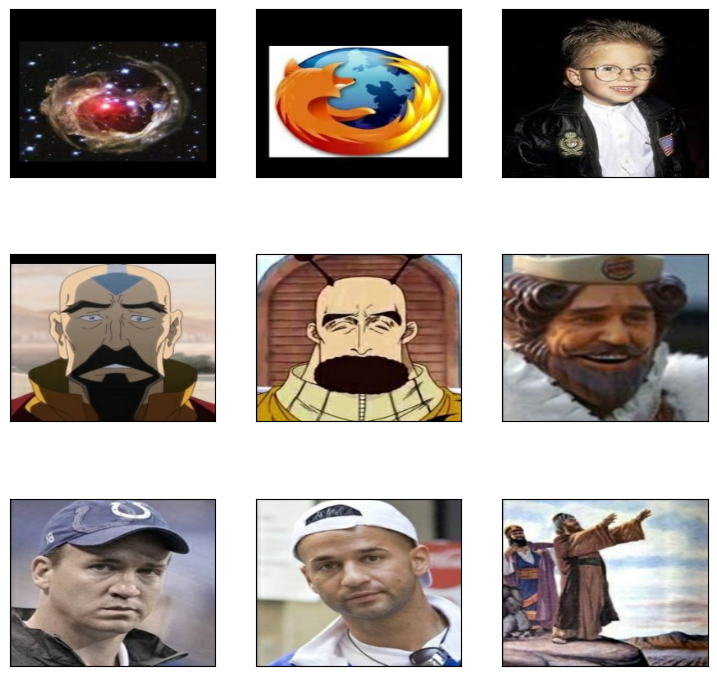

In [252]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


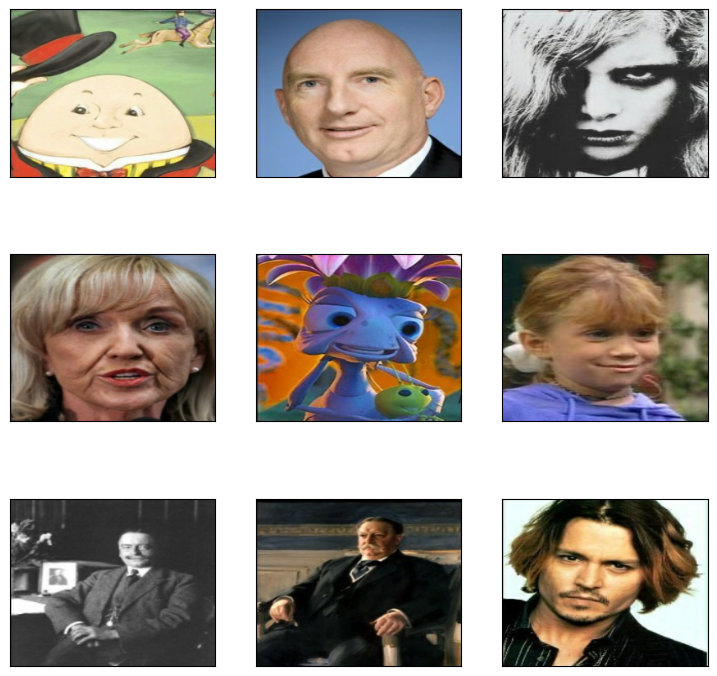

In [253]:
visualize(*list(val_dataset.take(1).as_numpy_iterator())[0])

In [254]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.Dropout(0.5)(dense1)  # 添加 Dropout 层
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.Dropout(0.5)(dense2)  # 添加 Dropout 层
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [255]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [256]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=1):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [257]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), weighted_metrics=["loss"])
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
297/297 [==============================] - 139s 423ms/step - loss: 0.7765 - val_loss: 0.7290
Epoch 2/10
297/297 [==============================] - 121s 409ms/step - loss: 0.5637 - val_loss: 0.4299
Epoch 3/10
297/297 [==============================] - 122s 411ms/step - loss: 0.4492 - val_loss: 0.4036
Epoch 4/10
297/297 [==============================] - 121s 408ms/step - loss: 0.3814 - val_loss: 0.4251
Epoch 5/10
297/297 [==============================] - 121s 407ms/step - loss: 0.3050 - val_loss: 0.2665
Epoch 6/10
297/297 [==============================] - 121s 408ms/step - loss: 0.2705 - val_loss: 0.2100
Epoch 7/10
297/297 [==============================] - 121s 408ms/step - loss: 0.2307 - val_loss: 0.1457
Epoch 8/10
297/297 [==============================] - 121s 408ms/step - loss: 0.1927 - val_loss: 0.1819
Epoch 9/10
297/297 [==============================] - 121s 407ms/step - loss: 0.1833 - val_loss: 0.4065
Epoch 10/10
297/297 [==============================] - 121s 407m

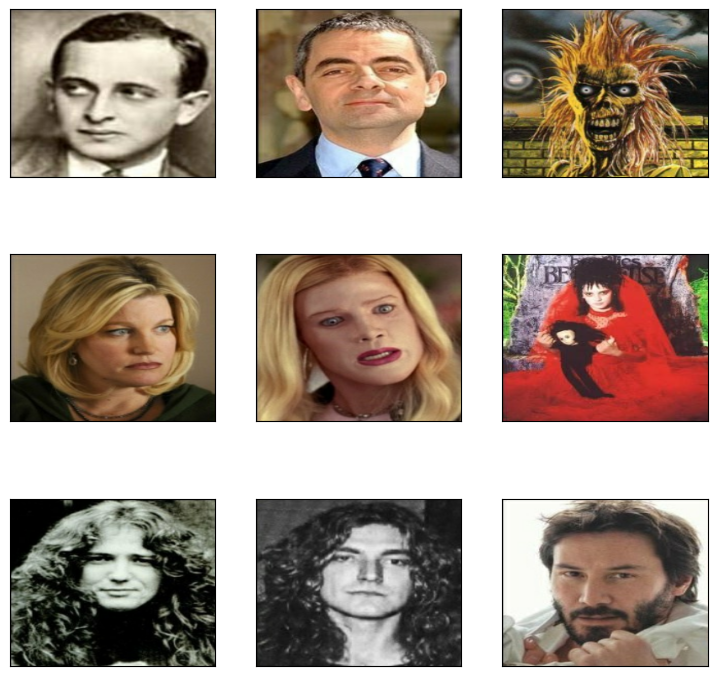

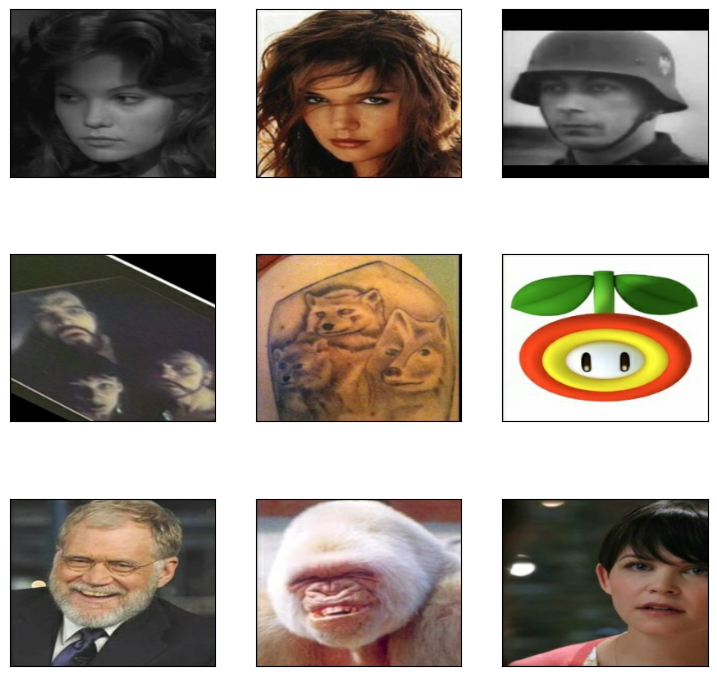

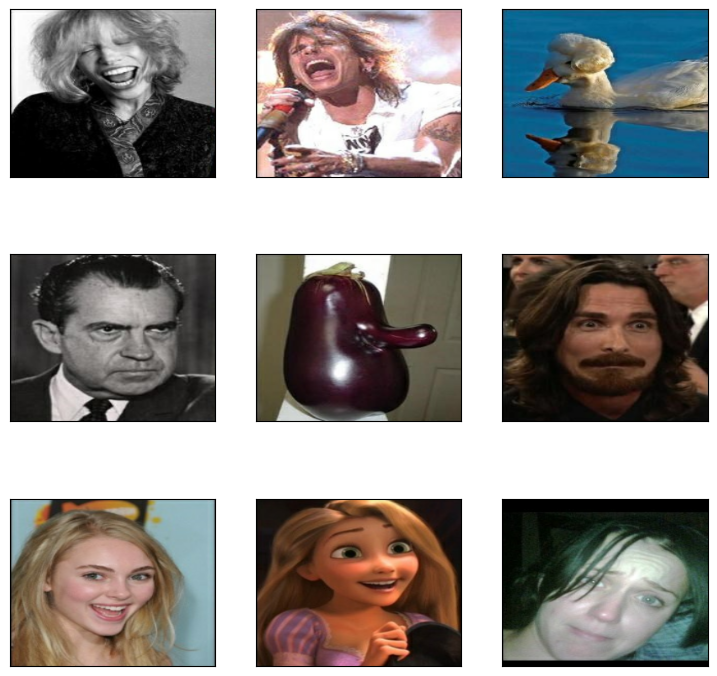

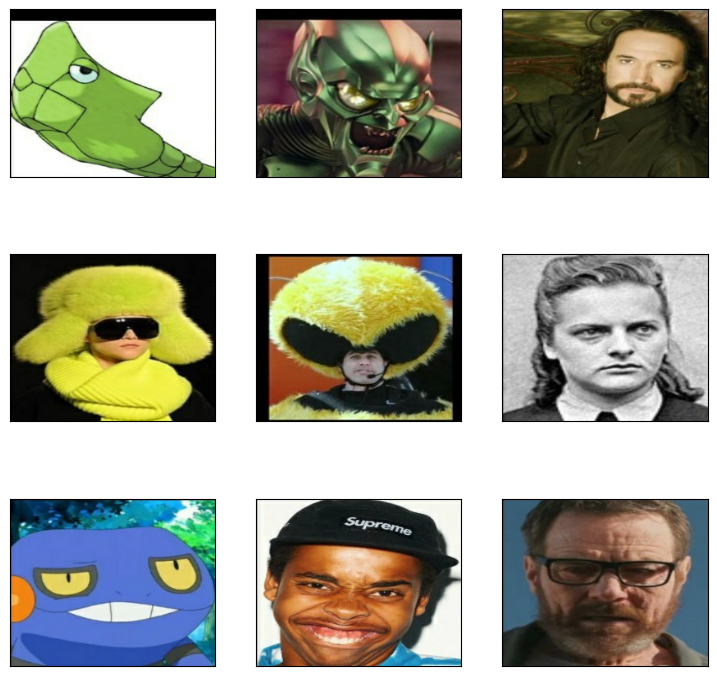

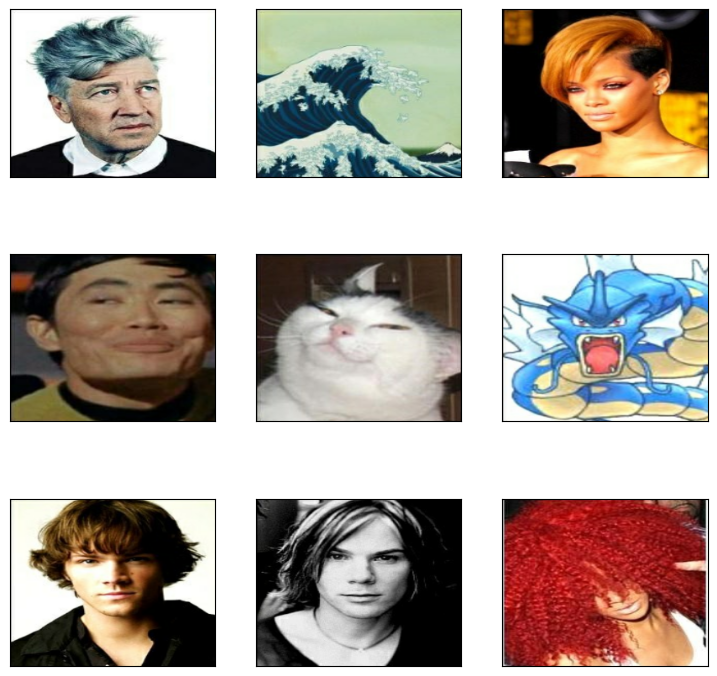

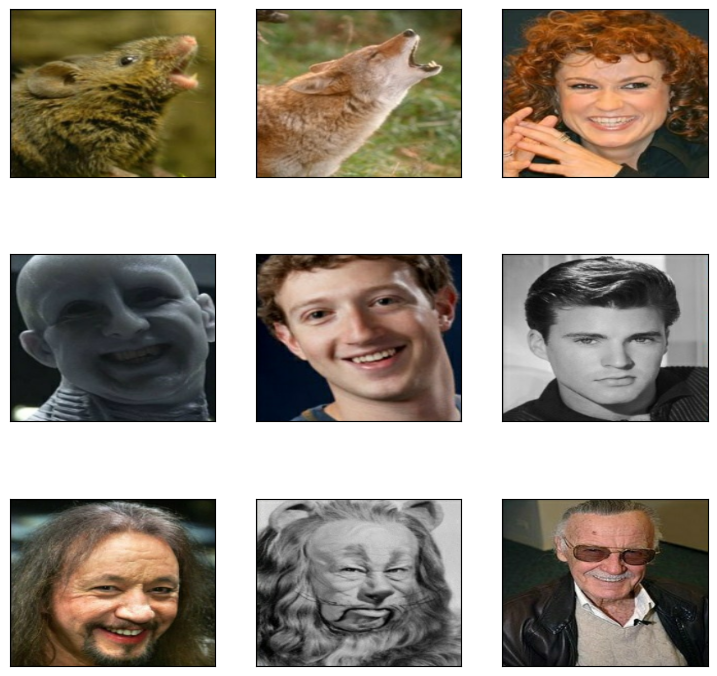

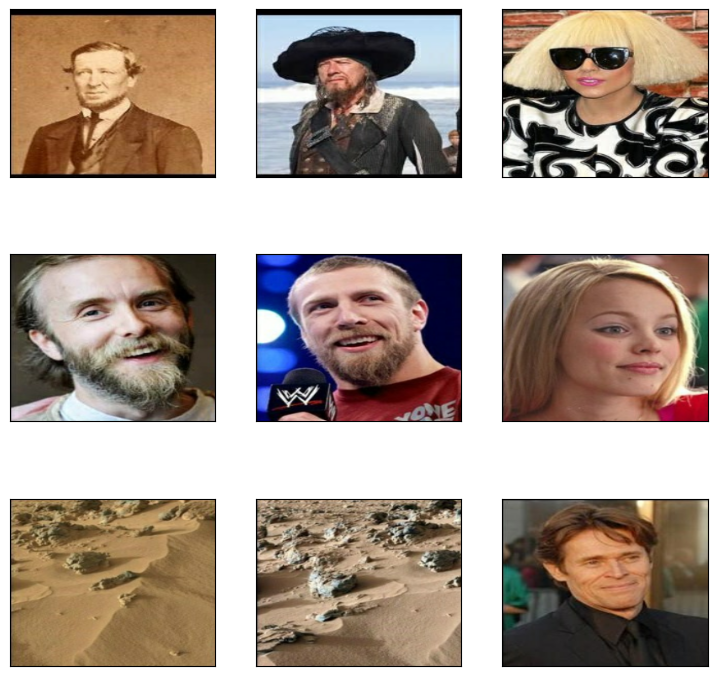

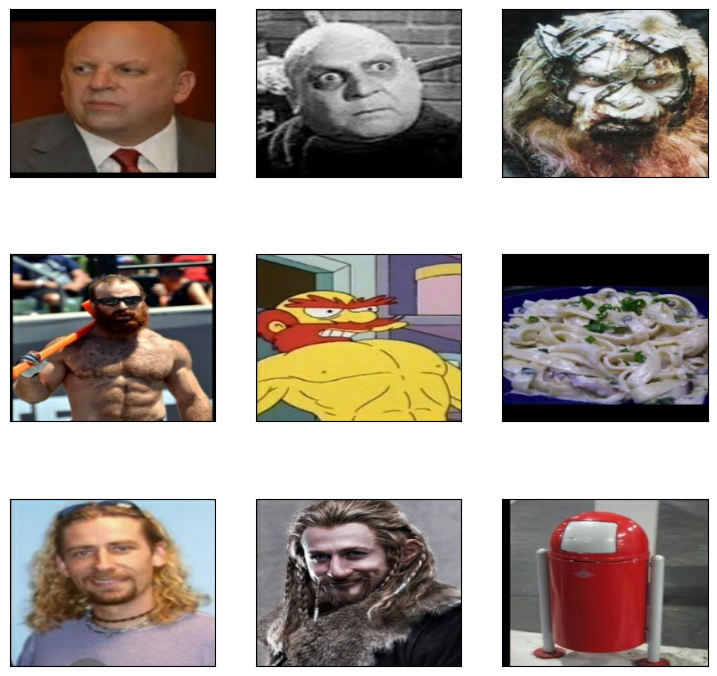

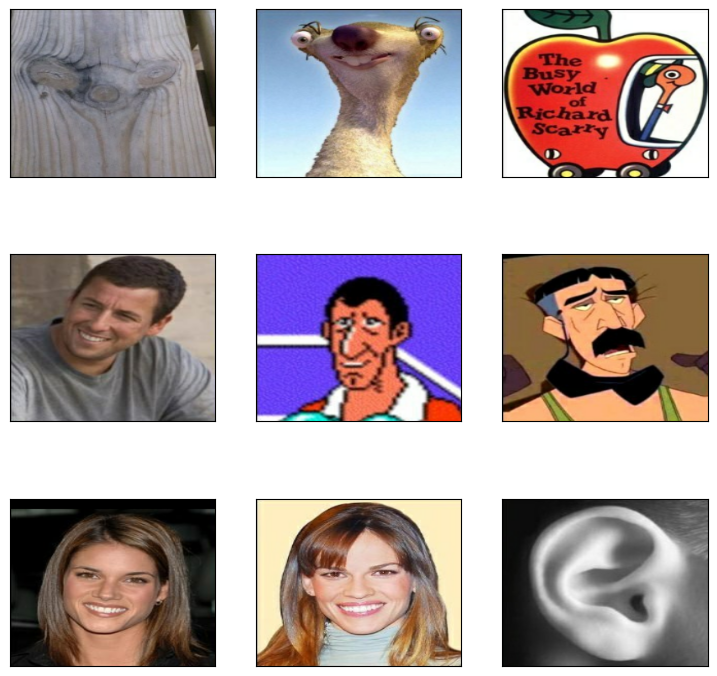

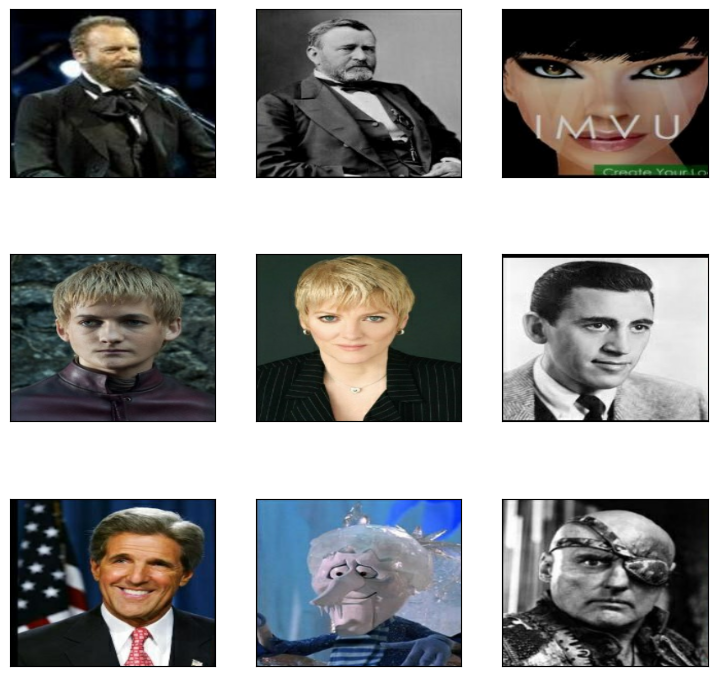

In [258]:
sample = next(iter(val_dataset))
for i in range(10):
  visualize(sample[0][i*3:i*3+3],sample[1][i*3:i*3+3],sample[2][i*3:i*3+3])

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [259]:
# print(anchor_embedding[0])
# print(positive_embedding[0])
# print(negative_embedding[1])
cosine_similarity = metrics.CosineSimilarity()

def image_simi(lft,rht):
  return 1 - tf.math.tanh(tf.reduce_sum(tf.square(lft - rht),-1))
  # return cosine_similarity(lft,rht)

for i in range(32):
  print(i)
  positive_similarity = tf.math.tanh(tf.reduce_sum(tf.square(anchor_embedding[i] - positive_embedding[i])))
  print("Positive similarity:", positive_similarity.numpy())

  negative_similarity = tf.math.tanh(tf.reduce_sum(tf.square(anchor_embedding[i] - negative_embedding[i])))
  print("Negative similarity", negative_similarity.numpy())

0
Positive similarity: 0.9934948
Negative similarity 0.9986758
1
Positive similarity: 0.8998001
Negative similarity 0.9999831
2
Positive similarity: 0.99914384
Negative similarity 1.0
3
Positive similarity: 0.9574461
Negative similarity 0.9941452
4
Positive similarity: 0.99999696
Negative similarity 0.9999995
5
Positive similarity: 0.8937503
Negative similarity 0.9944807
6
Positive similarity: 0.9992043
Negative similarity 0.9992273
7
Positive similarity: 0.9942722
Negative similarity 0.9998665
8
Positive similarity: 0.9828617
Negative similarity 0.986027
9
Positive similarity: 0.99886113
Negative similarity 0.9999927
10
Positive similarity: 0.9999267
Negative similarity 0.9999926
11
Positive similarity: 0.96151173
Negative similarity 0.99471426
12
Positive similarity: 0.99925685
Negative similarity 1.0
13
Positive similarity: 0.97113127
Negative similarity 0.999753
14
Positive similarity: 0.9999977
Negative similarity 1.0
15
Positive similarity: 0.6351655
Negative similarity 0.9902842

In [260]:
# cosine_similarity = metrics.CosineSimilarity()

# positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
# print("Positive similarity:", positive_similarity.numpy())

# negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
# print("Negative similarity", negative_similarity.numpy())

In [261]:
test_pair=pd.read_csv(root + "test_candidates.csv")
test_data = []
# for i in range(len(test_pair)):
#     left_path = test_pair.left[i] + '.jpg'
#     for j in range(0,len((test_pair.loc[i,"c0":"c19"])),2):
#         temp = []
#         right1_path = test_pair.loc[i,"c0":"c19"][j] + '.jpg'
#         right2_path = test_pair.loc[i,"c0":"c19"][j + 1] + '.jpg'
#         temp.append(left_path)
#         temp.append(right1_path)
#         temp.append(right2_path)
#         test_data.append(temp)

In [262]:
def preprocess_test_pair(anchor, test):
    """
    Given the filenames corresponding to the two images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(test),
    )

In [263]:
test_pairs = []
for i in range(len(test_pair)):
    left_path = root + 'test/left/' + test_pair.left[i] + '.jpg'
    for j in range(0, len((test_pair.loc[i, "c0":"c19"]))):
        right1_path = root + 'test/right/' + test_pair.loc[i, "c0":"c19"][j] + '.jpg'
        test_pairs.append((left_path, right1_path))
def generator():
    for pair in test_pairs:
        yield pair

test_dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)
test_dataset = test_dataset.map(
    lambda anchor, test: preprocess_test_pair(anchor, test)
)
test_dataset = test_dataset.batch(32, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)

In [264]:
test_pairs[:20]

[('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/kyr.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/qqo.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/xpv.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/tnd.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/xal.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/pvr.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/nsb.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/yzv.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/ahb.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/mlm.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/drb.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/vqu.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/vzr.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/test/right/kxe.jpg'),
 ('CV-Project/test/left/abm.jpg', 'CV-Project/te

In [265]:
def predict(dataset):
    simi_scores = []
    count = 0
    for batch in dataset:
        anchor_images, test_images = batch

        # 使用模型获取图像嵌入
        anchor_embeddings = embedding(resnet.preprocess_input(anchor_images))
        test_embeddings = embedding(resnet.preprocess_input(test_images))

        # 计算每个图像对的相似度
        batch_simi_scores = [image_simi(anchor_embedding, test_embedding)
                             for anchor_embedding, test_embedding in zip(anchor_embeddings, test_embeddings)]

        # 将相似度添加到结果列表中
        simi_scores.extend(batch_simi_scores)
        count += 32
        if count % 320 == 0:
          print(count)
    return simi_scores

# # 调用predict函数并传递test_dataset
# simi_scores = predict(test_dataset)


In [266]:
# test_dataset[:20]

In [267]:
# 获取两个图像的嵌入向量
# similarity = []
# count = 0
# for test_left, test_right1, test_right2 in test_data:
#     count += 1
#     # print(test_left + " ---- " + test_right)
#     anchor_image_path = root + "test/left/" + test_left
#     test_image_path1 = root + "test/right/" + test_right1
#     test_image_path2 = root + "test/right/" + test_right2

# # 计算两个嵌入向量之间的相似度
#     distance1, distance2 = predict(anchor_image_path, test_image_path1, test_image_path2)
#     similarity.append(distance1.numpy())
#     similarity.append(distance2.numpy())
#     if count % 1000 == 0:
#         print(count)


In [268]:
simi = predict(test_dataset)

320
640
960
1280
1600
1920
2240
2560
2880
3200
3520
3840
4160
4480
4800
5120
5440
5760
6080
6400
6720
7040
7360
7680
8000
8320
8640
8960
9280
9600
9920
10240
10560
10880
11200
11520
11840
12160
12480
12800
13120
13440
13760
14080
14400
14720
15040
15360
15680
16000
16320
16640
16960
17280
17600
17920
18240
18560
18880
19200
19520
19840
20160
20480
20800
21120
21440
21760
22080
22400
22720
23040
23360
23680
24000
24320
24640
24960
25280
25600
25920
26240
26560
26880
27200
27520
27840
28160
28480
28800
29120
29440
29760
30080
30400
30720
31040
31360
31680
32000
32320
32640
32960
33280
33600
33920
34240
34560
34880
35200
35520
35840
36160
36480
36800
37120
37440
37760
38080
38400
38720
39040
39360
39680
40000


In [269]:
simi

[<tf.Tensor: shape=(), dtype=float32, numpy=0.016931832>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0010738969>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.010231137>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.011012733>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.053166926>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0018344522>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00026410818>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.001946032>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.2470951e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00035101175>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.048597276>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.012988329>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.21974128>,
 <tf.Tensor: shape=(), dtype=float32, n

In [270]:
import csv

# 假设 similarity 是你的 Tensor 列表

# 转换Tensor为字符串，并保持小数点后的精度
similarity_str = [str(sim.numpy()) for sim in simi]

# 读取CSV文件
with open(root + 'submission_resNet.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]

# 更新CSV文件的值
for i in range(1, len(rows)):  # 从第二行开始，因为第一行是标题行
    for j in range(1, 21):  # 对于c0到c19
        rows[i][j] = similarity_str[(i-1)*20 + (j-1)]

# 将更新后的值写回CSV文件
with open(root + 'submission_resNet.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)

In [271]:
from google.colab import files

# 文件的路径
file_path = root + 'submission_resNet.csv'

# 触发下载
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [272]:
from google.colab import files

# 文件的路径
file_path = root + 'submission_resNet.csv'

# 触发下载
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>